In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random

# Set seeds for reproducibility
random_seed = 4101  
random.seed(random_seed)
np.random.seed(random_seed)

final_merged_df = pd.read_csv("../data/final_merged_df.csv")
# Convert Date column to datetime
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'])

# 73 rows where mvel1 is -np.inf
show_mve1_inf = final_merged_df[final_merged_df['mvel1']==-np.inf]
# Drop them away
final_merged_df = final_merged_df[final_merged_df['mvel1']!=-np.inf]

# Split the data into train and test sets
train_df = final_merged_df[final_merged_df['Date'] <= '2015-12-31'].copy()
test_df = final_merged_df[final_merged_df['Date'] > '2015-12-31'].copy()

                            OLS Regression Results                            
Dep. Variable:           risk_premium   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3186.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:24:17   Log-Likelihood:             4.1301e+05
No. Observations:              203583   AIC:                        -8.260e+05
Df Residuals:                  203579   BIC:                        -8.260e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010   7.05e-05     14.566      0.0

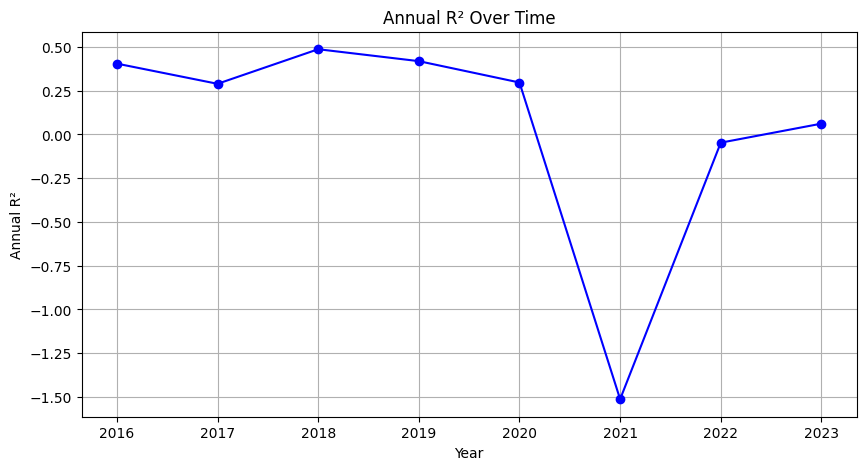

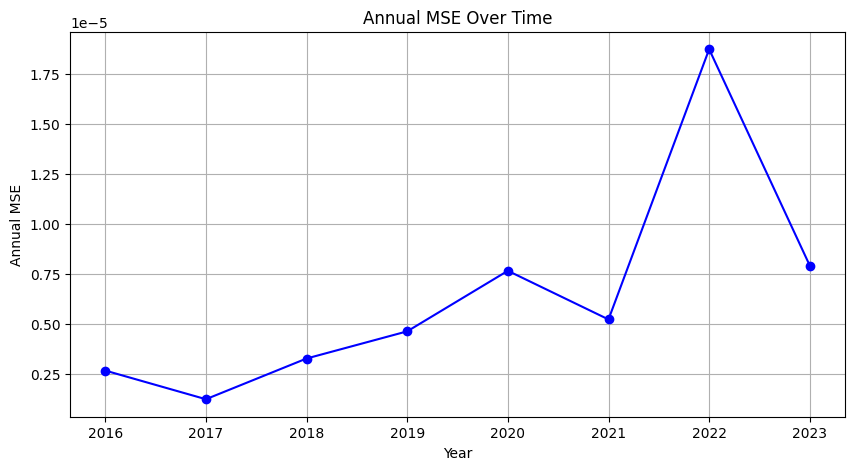

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the predictors and the target variable for the training set
X_train = train_df[['mvel1', 'bm', 'mom1m']]
y_train = train_df['risk_premium']  # Fix: Select only 'risk_premium'

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Add a constant to the standardized predictors
X_train_scaled = sm.add_constant(X_train_scaled)

# Fit the OLS model
model = sm.OLS(y_train, X_train_scaled).fit()

# Print the model summary
print(model.summary())

# Define the predictors and the target variable for the test set
X_test = test_df[['mvel1', 'bm', 'mom1m']]
y_test = test_df[['Date', 'risk_premium']]  # Keep 'Date' for monthly aggregation

# Standardize the test predictors using the same scaler
X_test_scaled = scaler.transform(X_test)

# Add a constant to the standardized predictors
X_test_scaled = sm.add_constant(X_test_scaled)

# Predict the values using the trained model
y_pred = model.predict(X_test_scaled)

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Date': test_df['Date'],
    'y_actual': y_test['risk_premium'],
    'y_predicted': y_pred
})

# Convert to monthly format and compute the mean
results_df['month'] = results_df['Date'].dt.to_period('M')
monthly_results = results_df.groupby('month')[['y_actual', 'y_predicted']].mean().reset_index()



# # Compute Monthly R-squared
# monthly_r2 = r2_score(monthly_results['y_actual'], monthly_results['y_predicted'])
# print(f'Monthly R²: {monthly_r2}')

# # Compute Monthly Adjusted R-squared
# n_months = len(monthly_results)  # Number of months
# p_features = X_test_scaled.shape[1] - 1  # Number of predictors
# monthly_adj_r2 = 1 - (1 - monthly_r2) * (n_months - 1) / (n_months - p_features - 1)
# print(f'Monthly Adjusted R²: {monthly_adj_r2}')

# # Compute Monthly Mean Squared Error (MSE)
# monthly_mse = mean_squared_error(monthly_results['y_actual'], monthly_results['y_predicted'])
# print(f'Monthly Mean Squared Error: {monthly_mse}')



# Now, compute the annual R² by averaging the monthly R² values
# Extract the year from the 'month' column
monthly_results['year'] = monthly_results['month'].dt.year

# Group by year and calculate the average R² for each year
annual_r2_df = monthly_results.groupby('year')[monthly_results.columns.tolist()].apply(
    lambda df: r2_score(df['y_actual'], df['y_predicted'])
).reset_index(name='annual_r2')

# Plot Annual R² Over Time
plt.figure(figsize=(10, 5))
plt.plot(annual_r2_df['year'], annual_r2_df['annual_r2'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Annual R²')
plt.title('Annual R² Over Time')
plt.grid(True)
plt.show()

# Group by year and calculate the average MSE for each year
annual_MSE_df = monthly_results.groupby('year')[monthly_results.columns.tolist()].apply(
    lambda df: mean_squared_error(df['y_actual'], df['y_predicted'])
).reset_index(name='annual_MSE')

# Plot Annual MSE Over Time
plt.figure(figsize=(10, 5))
plt.plot(annual_MSE_df['year'], annual_MSE_df['annual_MSE'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Annual MSE')
plt.title('Annual MSE Over Time')
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:           risk_premium   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     144.4
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:25:37   Log-Likelihood:             4.1321e+05
No. Observations:              203583   AIC:                        -8.263e+05
Df Residuals:                  203513   BIC:                        -8.256e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010   7.05e-05     14.578      0.0

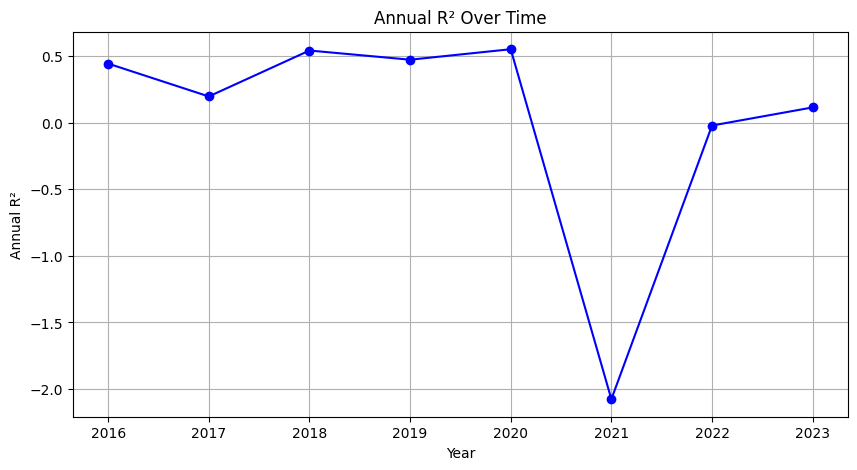

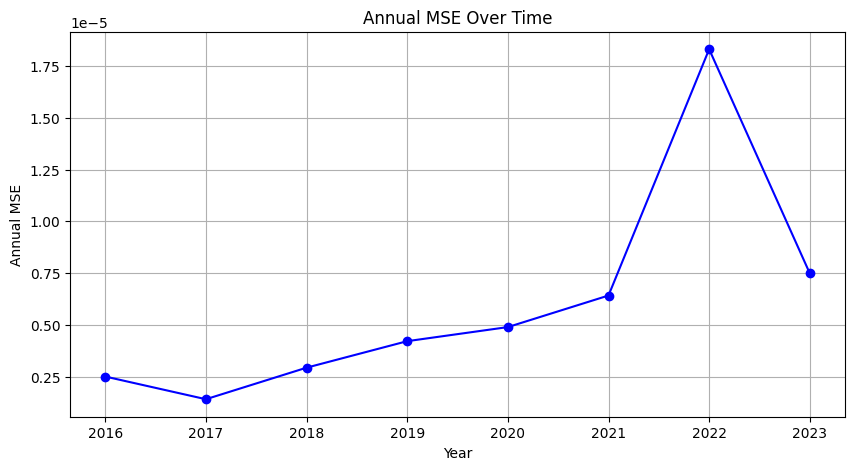

In [43]:
# Define the predictors and the target variable for the training set
X_train = train_df.drop(columns=['Date', 'risk_premium'])  # Drop 'Date' and 'risk_premium'
y_train = train_df['risk_premium']  # Fix: Select only 'risk_premium'

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Add a constant to the standardized predictors
X_train_scaled = sm.add_constant(X_train_scaled)

# Fit the OLS model
model = sm.OLS(y_train, X_train_scaled).fit()

# Print the model summary
print(model.summary())

# Define the predictors and the target variable for the test set
X_test = test_df.drop(columns=['Date', 'risk_premium'])  # Drop 'Date' and 'risk_premium'
y_test = test_df[['Date', 'risk_premium']]  # Keep 'Date' for monthly aggregation

# Standardize the test predictors using the same scaler
X_test_scaled = scaler.transform(X_test)

# Add a constant to the standardized predictors
X_test_scaled = sm.add_constant(X_test_scaled)

# Predict the values using the trained model
y_pred = model.predict(X_test_scaled)

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Date': test_df['Date'],
    'y_actual': y_test['risk_premium'],
    'y_predicted': y_pred
})

# Convert to monthly format and compute the mean
results_df['month'] = results_df['Date'].dt.to_period('M')
monthly_results = results_df.groupby('month')[['y_actual', 'y_predicted']].mean().reset_index()



# # Compute Monthly R-squared
# monthly_r2 = r2_score(monthly_results['y_actual'], monthly_results['y_predicted'])
# print(f'Monthly R²: {monthly_r2}')

# # Compute Monthly Adjusted R-squared
# n_months = len(monthly_results)  # Number of months
# p_features = X_test_scaled.shape[1] - 1  # Number of predictors
# monthly_adj_r2 = 1 - (1 - monthly_r2) * (n_months - 1) / (n_months - p_features - 1)
# print(f'Monthly Adjusted R²: {monthly_adj_r2}')

# # Compute Monthly Mean Squared Error (MSE)
# monthly_mse = mean_squared_error(monthly_results['y_actual'], monthly_results['y_predicted'])
# print(f'Monthly Mean Squared Error: {monthly_mse}')



# Now, compute the annual R² by averaging the monthly R² values
# Extract the year from the 'month' column
monthly_results['year'] = monthly_results['month'].dt.year

# Group by year and calculate the average R² for each year
annual_r2_df = monthly_results.groupby('year')[monthly_results.columns.tolist()].apply(
    lambda df: r2_score(df['y_actual'], df['y_predicted'])
).reset_index(name='annual_r2')

# Plot Annual R² Over Time
plt.figure(figsize=(10, 5))
plt.plot(annual_r2_df['year'], annual_r2_df['annual_r2'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Annual R²')
plt.title('Annual R² Over Time')
plt.grid(True)
plt.show()

# Group by year and calculate the average MSE for each year
annual_MSE_df = monthly_results.groupby('year')[monthly_results.columns.tolist()].apply(
    lambda df: mean_squared_error(df['y_actual'], df['y_predicted'])
).reset_index(name='annual_MSE')

# Plot Annual MSE Over Time
plt.figure(figsize=(10, 5))
plt.plot(annual_MSE_df['year'], annual_MSE_df['annual_MSE'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Annual MSE')
plt.title('Annual MSE Over Time')
plt.grid(True)
plt.show()